In [1]:
import dolfin as df
import matplotlib.pyplot as plt
import numpy as np

Lx = 2.
H = 1.
Ny = 30

force = 10.
density = 1.
viscosity = 0.02

T = 1.0
dt = 0.1

# Subdomain for Periodic boundary condition
class PeriodicBoundary(df.SubDomain):
    def inside(self, x, on_boundary):
        return bool(x[0] < df.DOLFIN_EPS and x[0] > -df.DOLFIN_EPS and on_boundary)

    def map(self, x, y):
        y[0] = x[0] - Lx
        y[1] = x[1]

def wall(x, on_boundary):
    return on_boundary and (x[1] < df.DOLFIN_EPS or x[1] > H-df.DOLFIN_EPS)

pbc = PeriodicBoundary()

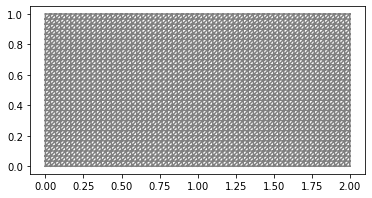

In [2]:
#mesh = df.UnitSquareMesh(20, 20)

mesh = df.RectangleMesh(df.Point(0., 0.), df.Point(Lx, H), int(Lx/H*Ny), Ny)

xy = mesh.coordinates()
x = xy[:, 0]
y = xy[:, 1]
#y = (y-0.5*H)*(1 + 0.5*np.sin(x*np.pi)**2)+0.5*H
#xy[:, 1] = y
#mesh.coordinates()[:] = xy

df.plot(mesh)

In [3]:
V_el = df.VectorElement("Lagrange", mesh.ufl_cell(), 2)
P_el = df.FiniteElement("Lagrange", mesh.ufl_cell(), 1)

V = df.FunctionSpace(mesh, V_el, constrained_domain=pbc)
P = df.FunctionSpace(mesh, P_el, constrained_domain=pbc)

u_1 = df.Function(V)
p_1 = df.Function(P)

u = df.TrialFunction(V)
v = df.TestFunction(V)
u_ = df.Function(V)
u_.rename("u", "tmp")

p = df.TrialFunction(P)
q = df.TestFunction(P)
p_ = df.Function(P)

f = df.Constant((force, 0.))
rho = df.Constant(density)
mu = df.Constant(viscosity)

F_u_pred = (rho*df.dot(u - u_1, v)
            + dt*rho*df.dot(df.dot(u_1, df.nabla_grad(u)), v)
            + dt*mu*df.inner(df.nabla_grad(u), df.nabla_grad(v))
            - dt*p_1 * df.div(v) - dt*df.dot(f, v))*df.dx

F_p_corr = (dt*df.dot(df.nabla_grad(p - p_1), df.nabla_grad(q))
            + rho*df.div(u_)*q )*df.dx

F_u_corr = (rho*df.dot(u - u_, v) - dt*(p_ - p_1)*df.div(v))*df.dx

bc_u = df.DirichletBC(V, df.Constant((0., 0.)), wall)
bc_p = df.DirichletBC(P, df.Constant(0.), "x[0] < DOLFIN_EPS && x[1] < DOLFIN_EPS", "pointwise")

t = 0.
Ux = []

tstepfile = df.XDMFFile(mesh.mpi_comm(), "u.xdmf")
tstepfile.parameters["rewrite_function_mesh"] = False
tstepfile.parameters["flush_output"] = True

while t <= T:
    # Update variables
    t += dt
    print("t={}".format(t))
    u_1.assign(u_)
    p_1.assign(p_)
    
    # Predict u
    df.solve(df.lhs(F_u_pred) == df.rhs(F_u_pred), u_, bc_u)
    
    # Correct p
    df.solve(df.lhs(F_p_corr) == df.rhs(F_p_corr), p_, bc_p)
    
    # Correct u
    df.solve(df.lhs(F_u_corr) == df.rhs(F_u_corr), u_, bc_u)
    
    #df.plot(u_[0])
    Ux.append(df.assemble(u_[0]*df.dx))
    
    tstepfile.write(u_, float(t))
    
tstepfile.close()

t=0.1
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
t=0.2
Solving linear variational problem.
Solving linear variational problem.
t=0.30000000000000004
Solving linear variational problem.
Solving linear variational problem.
t=0.4Solving linear variational problem.
Solving linear variational problem.

Solving linear variational problem.
t=0.5Solving linear variational problem.
Solving linear variational problem.

Solving linear variational problem.
Solving linear variation

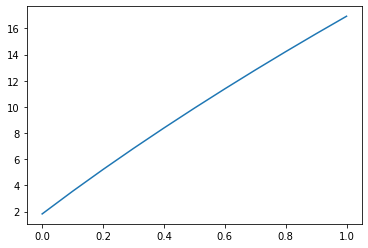

In [4]:
plt.plot(np.linspace(0., T, len(Ux)), Ux)

In [5]:
Ux_analytic = force*H/(12*viscosity)

In [6]:
Ux_analytic

41.66666666666667

Calling FFC just-in-time (JIT) compiler, this may take some time.
Object cannot be plotted directly, projecting to piecewise linears.


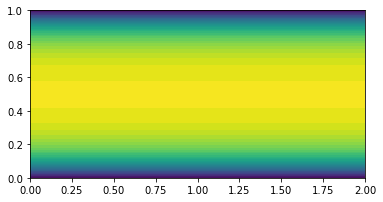

In [7]:
df.plot(u_[0])